**Kagle user name and access token**

In [1]:
import os
os.environ["KAGGLE_USERNAME"] = "abdelrahmansaied20"
os.environ["KAGGLE_KEY"] = "ea78e7faac9abf4378bb9b53d0621a73"

**Download dataset from kaggle**

In [2]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 41.1MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.7MB/s]


In [ ]:
!unzip /content/chest-xray-pneumonia.zip

**### load drive to get/store model**

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


**set main configurations**

In [6]:
BATH_BASE = os.path.join("chest_xray" , "chest_xray")
TRAIN_PATH = os.path.join(BATH_BASE , "train")
TEST_PATH = os.path.join(BATH_BASE , "test")
VAL_PATH = os.path.join(BATH_BASE , "val")

In [16]:
TARGET_LABELS = ["NORMAL" , "PNEUMONIA"]
SUPPORT_EXTENTIONS = ["png" , "jpg" , "jpeg"]
IM_HEIGHT , IM_WIDTH = 100 , 100
NO_OF_CHANNELS = 1 # gray 3, rgb 
SHUFFLE = True

 **data cleaning**

In [10]:
import cv2 
import numpy as np

In [14]:
def load_data(base_folder_path):
  x_container = []
  y_container = []
  images_count = {}
  for folder_name in os.listdir(base_folder_path):
    if folder_name not in TARGET_LABELS:
      continue
    target_id = TARGET_LABELS.index(folder_name)
    if target_id not in images_count:
      images_count[target_id] = 0
    folder_path = os.path.join(base_folder_path, folder_name)
    for image_name in os.listdir(folder_path):
      image_ext = image_name.split(".")[-1].lower()
      if image_ext not in SUPPORT_EXTENTIONS:
        continue 
      image_path = os.path.join(folder_path, image_name)
      try:
        image = cv2.imread(image_path) # bgr
      except Exception as e:
        print(f"{image_name} >> {e}")
      else:
        if NO_OF_CHANNELS == 1:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        resized_image = cv2.resize(image, (IM_HEIGHT, IM_WIDTH))
        scaled_image = resized_image.astype("float32")/255.0
        x_container.append(scaled_image)
        y_container.append(target_id)
        images_count[target_id] += 1
  # convert list > numpy arrays
  x_array = np.array(x_container, dtype=np.float32)
  num_of_images = len(x_container)
  x_array = x_array.reshape(num_of_images, IM_HEIGHT, IM_WIDTH, NO_OF_CHANNELS)
  y_array = np.array(y_container, dtype=np.uint8)
  if SHUFFLE is True:
    shuffled_indexs = np.arange(len(y_container))
    np.random.shuffle(shuffled_indexs)
    x_array = x_array[shuffled_indexs]
    y_array = y_array[shuffled_indexs]
  return x_array, y_array, images_count
        

In [17]:
x_train, y_train  , train_info = load_data(TRAIN_PATH)

In [18]:
x_test , y_test , test_info = load_data(TEST_PATH)

In [21]:
x_val, y_val  , test_val= load_data(VAL_PATH)

In [20]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7fbd90f99d90>,
 [Text(0, 0, 'NORMAL'), Text(0, 0, 'PNEUMONIA')])

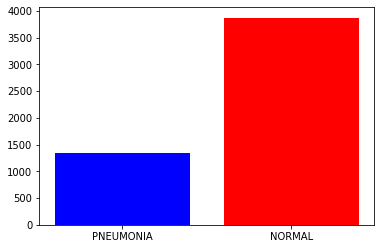

In [22]:
plt.bar(train_info.keys() , train_info.values() , color=['red' , "blue" ])
plt.xticks(list(train_info.keys()) , TARGET_LABELS )

as you can notice there is a large in balance in the dataset

one way to solve this is by using class_weight
and it's basically works by penalizing the mistakes in samples of certain the higher class-weight means you want to put more emphasis on a class. From what you say it seems class 1 is 3 to 4 times more frequent than class 0. So you should increase the class_weight of class 1 relative to class 0

‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y))


In [23]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced" , np.unique(y_train) , y_train)
# convert class weights to dict
print(class_weights)
class_weights_dict = {k:class_weights[k] for k in range(len(class_weights))}
print(class_weights_dict)

[1.9448173  0.67303226]
{0: 1.9448173005219984, 1: 0.6730322580645162}


## visualize sample from the  data

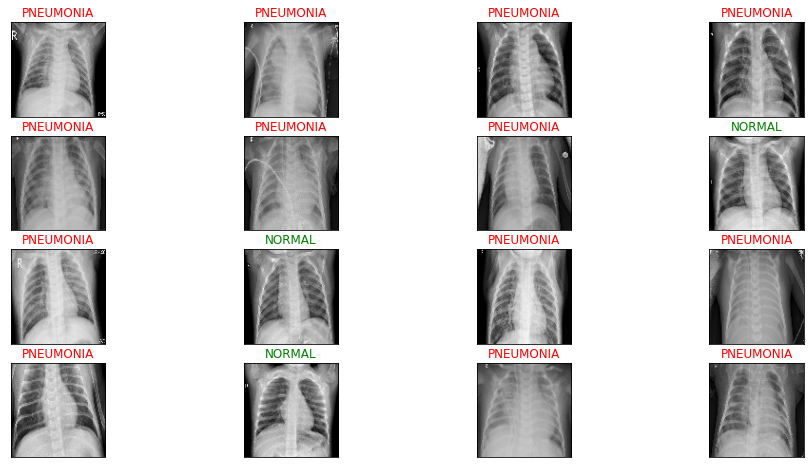

In [26]:
fig = plt.figure(figsize=(16, 8))
image_indexs = np.random.choice(x_train.shape[0], 16)
for i in range(16):
  ax= fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
  image_index = image_indexs[i]
  gray_image = x_train[image_index].reshape((IM_HEIGHT, IM_WIDTH))
  ax.imshow(gray_image,  cmap="gray")
  # TARGET_LABELS
  target_value = y_train[image_index]
  lbl = TARGET_LABELS[target_value] # 
  if target_value == 0:
    color = "green"
  else:
    color = "red"
  ax.set_title(lbl, color=color)

## Image Data Augmentation
Data augmentation encompasses a wide range of techniques used to generate “new” training samples from the original ones by applying random jitters and perturbations (but at the same time ensuring that the class labels of the data are not changed).

the Keras ImageDataGenerator class actually works by:


1.   Accepting a batch of images
2.   aking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.)
3.   Replacing the original batch with the new, randomly transformed batch
4.   Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

the following cell is only for illustration

In [27]:
from keras_preprocessing.image import ImageDataGenerator

In [29]:
sample_batch = x_train[0].reshape(1 , IAMGE_HEIGHT , IM_WIDTH , NO_OF_CHANNELS )
gen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range=0.05, 
    height_shift_range=0.05
)

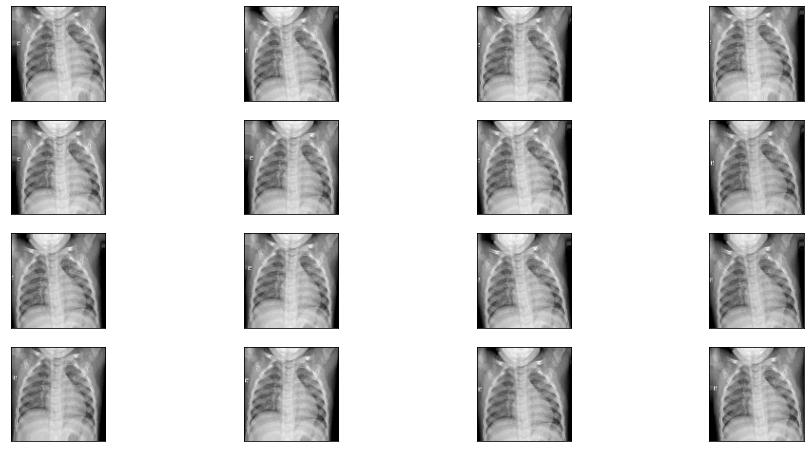

In [30]:
fig = plt.figure(figsize=(16,8))
for i in range(16):
  ax = fig.add_subplot(4,4,i+1 , xticks=[] , yticks=[])
  gen_images = gen.flow(sample_batch , batch_size=1)
  gray_image = gen_images[0].reshape(IAMGE_HEIGHT,IM_WIDTH)
  ax.imshow(gray_image , cmap = "gray")


In [31]:
train_data_gen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range=0.05, 
    height_shift_range=0.05
)

In [32]:
if not os.path.isdir("aug_images"):
  os.mkdir("aug_images")


In [33]:
x_train.shape

(5216, 100, 100, 1)

In [34]:
training_batches = train_data_gen.flow(x_train, y_train, batch_size=32, save_to_dir="aug_images", save_prefix='train_', save_format='png')

In [35]:
val_data_gen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range=0.05, 
    height_shift_range=0.05
)

In [36]:
val_batches = train_data_gen.flow(x_val, y_val, batch_size=32, save_to_dir="aug_images", save_prefix='val_', save_format='png')

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add( Conv2D(filters=16, kernel_size=5, padding='same', activation='relu', input_shape=( IM_HEIGHT, IM_WIDTH, NO_OF_CHANNELS)))
model.add(BatchNormalization())
model.add( Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'))
model.add( MaxPool2D(pool_size=2))

#
model.add( Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
BatchNormalization
model.add( MaxPool2D(pool_size=2))
#
model.add( Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add( MaxPool2D(pool_size=2))
model.add(Dropout(0.4))

#
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.4))
# output layer
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        1

In [38]:
model.compile(loss="binary_crossentropy" , metrics=["accuracy"])

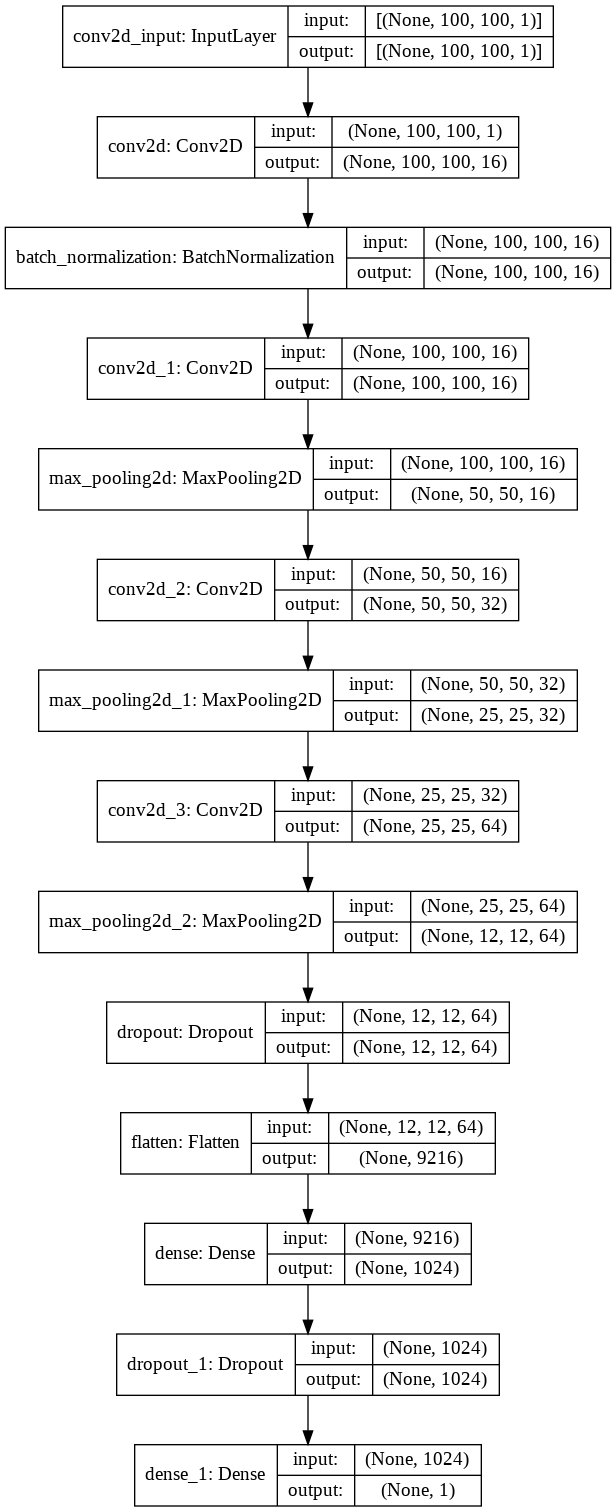

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(model , to_file="chest_model.png" , show_shapes=True)

In [49]:
class_weights_dict

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [54]:
from keras.callbacks import  EarlyStopping , ModelCheckpoint
# EarlyStopping used to if val_loss not enhance it stop training 
es = EarlyStopping(monitor="val_loss", patience=10, verbose=1)
# save best model only 
mc = ModelCheckpoint(monitor="val_loss",filepath="best_model.hdf5", verbose=1, save_best_only=True)

history = model.fit_generator(
    generator = training_batches,
    validation_data = val_batches,
    steps_per_epoch = x_train.shape[0]//32,
    epochs=20,
    callbacks = [es, mc],
    class_weight = class_weights_dict
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 186s 1s/step - loss: 0.0999 - accuracy: 0.9705 - val_loss: 1.8373 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 1.83729, saving model to best_model.hdf5
Epoch 2/20
163/163 [==============================] - 186s 1s/step - loss: 0.1063 - accuracy: 0.9684 - val_loss: 1.0770 - val_accuracy: 0.7500

Epoch 00002: val_loss improved from 1.83729 to 1.07703, saving model to best_model.hdf5
Epoch 3/20
163/163 [==============================] - 186s 1s/step - loss: 0.1044 - accuracy: 0.9691 - val_loss: 0.2600 - val_accuracy: 0.8750

Epoch 00003: val_loss improved from 1.07703 to 0.25997, saving model to best_model.hdf5
Epoch 4/20
163/163 [==============================] - 187s 1s/step - loss: 0.1016 - accuracy: 0.9686 - val_loss: 0.8891 - val_accuracy: 0.7500

Epoch 00004: val_loss did not improve from 0.25997
Epoch 5/20
163/163 [==============================] - 190s 1s/step - loss: 0.0971 - accuracy: 0.9712 - val_loss: 

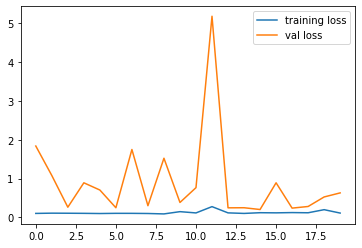

In [55]:
plt.plot(history.history["loss"] , label="training loss")
plt.plot(history.history["val_loss"] , label="val loss")
plt.legend()

In [56]:
model.evaluate(x_test, y_test)

20/20 [==============================] - 5s 234ms/step - loss: 2.9049 - accuracy: 0.6907


[2.90494704246521, 0.6907051205635071]

## to generate classification report

In [43]:
y_pred = model.predict(x_test) 

## remember the above output not 0/1 it's probability remember the sigmoid shape.
1. convert any p >= 0.5 to 1
2. convert any p < 0.5 to 0

In [44]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.95      0.45      0.61       234
           1       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



## display some images

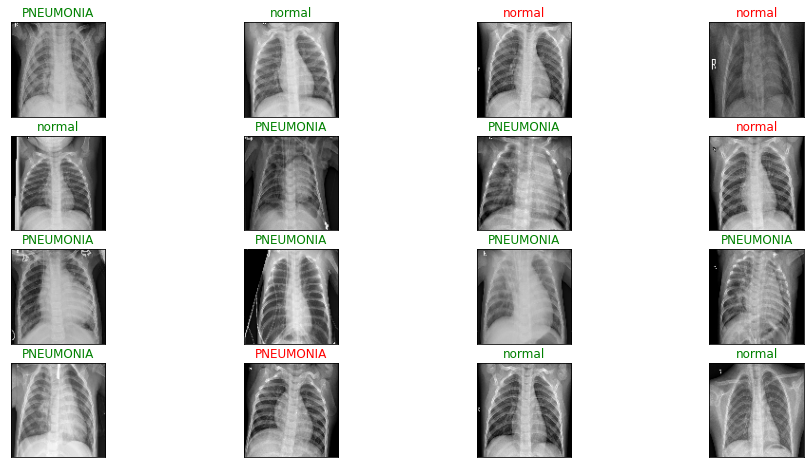

In [57]:
fig = plt.figure(figsize=(16,8)) # window size 16in * 8 in
random_indexs = np.random.choice(x_test.shape[0], 16)
for i in range(16):
  index = random_indexs[i]
  image = x_test[index].reshape(100,100)
  ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
  ax.imshow(image, cmap ="gray")
  if y_test[index] == 0:
    label = "normal"
  else:
    label = "PNEUMONIA"
  if y_test[index] == y_pred[index]:
    color = "green"
  else:
    color = "red"
  ax.set_title(label , c= color)

## store model

In [58]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!cp best_model.hdf5 /content/drive/MyDrive/machine_learning_models

**Test model**

In [ ]:
sample_image_path = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg"

In [ ]:
gray_image = cv2.imread(sample_image_path, 0)
resized_image = cv2.resize(gray_image, (100,100))
scaled_image = resized_image.astype("float32")/255.0
sample_batch = scaled_image.reshape(1, 100, 100, 1) # 1 image, 100, 100 dim , 1 no of chanels

In [ ]:
model.predict(sample_batch)